# <center> <b> <h1> Random Forest (Significance Score - Best N of Rois) </h1></b></center>

<h1>Explanation about it: <h1>
    <p style="font-weight: normal; font-size: 18px; text-align: justify;"> 
        in this file the goal is find the mos significants areas for the model,
        for this we used the random forest created in the lastone step of training, 
        in wich we have one randome Fores(.pkl) for each featur (area, thickness, volumen, MeanCurv), 
        whit all the features (148 for each subject composed for Rh and Lh. we used the attribute of
        <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_">   feature_importances.</a>, for know the significance of each feature at the 4 differentes models (RF).
        You have to take in count that the best model of training  was arroud 72% of accuracy, so 
        we have to no that the sum of all the significances will be 1, but this one represent a 7x% of
        accuracy of each model
    </p>
    <p style="font-weight: normal; font-size: 18px; text-align: justify;">
        we upgrade this part of our project for find the best number of most significant features for each model.
        we can say that each features was modeled with the same number of n_clasificator inside the random forest
    </p>
       

In [2]:
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
import pandas as pd
import numpy as np 

PATH_DATASETS = "../../2_Data_preparation/2_Split_Raw_Datasets/output/"
PATH_PKL = "../../3 Modeling/1. Random Forest ( All features)/output/"

In [3]:
def readCsvs():
    datasets = []
    constant1 = 'X_'
    constant2 = '_train'
    features = ['area', 'meancurv', 'thickness', 'volume']

    for feature in features:
        df = pd.read_csv(PATH_DATASETS + constant1 + feature + constant2 +'.csv', index_col=0)
        datasets.append({'name': feature, 'data': df})
    return datasets

In [4]:
def readClf():
    randomForests = []
    constant1 = "RandomForest (AllFeatures) "
    features = ['area', 'meancurv', 'thickness', 'volume']

    for feature in features:
        clf = joblib.load(PATH_PKL + constant1 + feature + '.pkl')
        randomForests.append({'name': feature, 'data': clf})
        
    return randomForests

In [5]:
def TrainRandomForest(data_x, data_y):
    """ create a random forest classifier and train it
    
    Parameters:
        data_x : pandas dataframe
            a formatted dataframe that has the value for each ROI of the brain
            evaluated by a feature (Area, Thickness, MeanCurv, Volumen) for 
            subjects the subjects that make up the kinf of dataset (training,
            test, validation)
        data_y : pandas dataframe
            a formatted dataframe that has the classification(weak, strong) for
            subjects the subjects that make up the kinf of dataset (training,
            test, validation)
            
    Returns:
        obb_score: float
           accuracy of the model
    """
    
    clf = RandomForestClassifier(n_estimators=6000, random_state=0, n_jobs=-1, oob_score=True, verbose=True)
    """* n_estimators : The number of trees in the forest.
        * n_jobs = -1 : use all the processors
        * oob_score = true: Whether to use out-of-bag samples to estimate the generalization accuracy.
        * verbose  = Controls the verbosity when fitting and predicting."""
    
    oob_score = clf.fit(data_x, data_y['class'].values)    # Train the classifier
    
    return oob_score.oob_score_

In [6]:
def best_number_of_Rois(significance,
                                   data_x,
                                   data_y, 
                                   step = 5):
    """
    A Function used to find the best number of rois for train a RF mondel.

    Parameters:
        significance : pandas dataframe
            a formatted dataframe that has the ROIs name and their significance
            ordered from most significant to less significant 
        data_x : pandas dataframe
            a formatted dataframe that has the value for each ROI of the brain
            evaluated by a feature (Area, Thickness, MeanCurv, Volumen) for 
            subjects the subjects that make up the kinf of dataset (training,
            test, validation)
        data_y : pandas dataframe
            a formatted dataframe that has the classification(weak, strong) for
            subjects the subjects that make up the kinf of dataset (training,
            test, validation)
        step : int
            the number of features that make up the step of evalutio (default 5)
            
    Returns:
        df_obb_score: pandas dataframe
            a formatted dataframe that has the number (quantity) of features 
            and the obb_score
    """
    
    df_obb_results = pd.DataFrame(columns=['quantity', 'obb_score']) 
    df_obb_results.set_index('quantity', inplace = True)
    
    number_of_Rois = step    # Initial number of feature for train the RF
    delta = step
    size_data = len(significance.index)
    
    conter = 0
    
    while number_of_Rois <= size_data:
        
        print("number_of_Rois: " + str(number_of_Rois) + '\n')
        
        acumulative_name_rois = significance[:number_of_Rois]    # take in step of @step Rois
        #print(acumulative_name_rois)
        
        acumulative_name_rois = acumulative_name_rois.index.values    # take just the names  
        #print(acumulative_name_rois)
        
        data_x_train = data_x[acumulative_name_rois].copy()
        #print(data_x_train)
        
        obb_score = TrainRandomForest(data_x_train, data_y)
        
        df_obb_results.at[number_of_Rois] = obb_score
        
        if((number_of_Rois + delta) >= size_data) and (conter == 0):
            number_of_Rois = size_data
            conter += 1
        elif(conter > 0):
            number_of_Rois = size_data + 10
        else:
            number_of_Rois += delta
        
    return df_obb_results

In [7]:
 def plot_graf(x, y = 0, 
               line_type = "-o",  
               title = "PLOT", 
               x_legend = "X", 
               y_legend = "Y",
               width = 15,
               heigh = 10):
        """
        A Function used to find the best number of rois for train a RF mondel.

        Parameters:
            x : array
                values of x axe 
            y : array
                values of y axe 
            line_type: str
                str that describes the line for the plot
            title: str
                str that describes the title
            x_legend: str
                legend of the x axe
            y_legend: str
                legend of the y axe
            width:int
                width of the plot
            heigh:int
                heigh of the plot
        """
        
        plt.figure(figsize=(width,heigh), dpi=100)
          
        if type(y) == int :
            plt.plot(x,line_type)
        else:
            plt.plot(x,y,line_type)
            
            # 1. Adjust x axis Ticks
            plt.xticks(ticks = x, fontsize=12, rotation=30, ha='center', va='top')

            # 2. Tick Parameters
            plt.tick_params(axis='both',bottom=True, top=True, left=True, right=True, direction='in', which='major', grid_color='blue')

        plt.grid(linestyle='--', linewidth=0.7, alpha=0.1)
        plt.title(title, fontsize = 14)
        plt.xlabel(x_legend, fontsize = 20)
        plt.ylabel(y_legend, fontsize = 20)
        plt.show()
        

In [8]:
def max_result_obb_score(df):
    arr = df['obb_score'].values
    arr = np.array(arr)
    
    position = np.where(arr == np.amax(arr))
    result = df.index.values[position]

    return result[0]

# 1. Prepare the data

In [9]:
df_X_tr = readCsvs()
df_X_tr[0]['data'].shape


(550, 148)

In [10]:
df_y_tr = pd.read_csv(PATH_DATASETS + 'Y_train.csv')
df_y_tr.shape

(550, 2)

# 1.  Identify the most significants features from R.A. classifier 

In [11]:
clfs = readClf()

In [12]:
tables = []

for feature, clf in zip(df_X_tr, clfs):
    
    data = feature['data']
    name = feature['name']
    Rf = clf['data']
    
    #not is a obb error is how much this variable apports to the model 
    df_features = pd.DataFrame(columns=['Name', 'Significance']) 
    df_features.set_index('Name', inplace = True)
    #df_features.head()

    for column in zip(data.columns.values, Rf.feature_importances_):
        #print(column)
        df_features.at[column[0]] = column[1]
    
    #print(df_features)
    #Total = df_features['Significance'].sum()
    #print ("for: " + name + " : " + str(Total))
    
    tables.append({'name' : name, 'data' : df_features})

    
#print(tables)

In [13]:
df_number_of_features = pd.DataFrame(columns=['Name', 'quantity']) 
df_number_of_features.set_index('Name', inplace = True)

In [14]:
def calc_acumulative_significance(significances):
    acumulative_significance = []
    acumulative_value = 0
    
    for significance in significances:
        acumulative_value += significance
        acumulative_significance.append(acumulative_value)
    
    #print(acumulative_significance)
    return acumulative_significance

number_of_Rois: 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.1s finished


number_of_Rois: 10



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.8s finished


number_of_Rois: 15



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.7s finished


number_of_Rois: 20



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.3s finished


number_of_Rois: 25



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.6s finished


number_of_Rois: 30



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.5s finished


number_of_Rois: 35



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.0s finished


number_of_Rois: 40



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.6s finished


number_of_Rois: 45



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.3s finished


number_of_Rois: 50



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.7s finished


number_of_Rois: 55



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.6s finished


number_of_Rois: 60



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.3s finished


number_of_Rois: 65



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.6s finished


number_of_Rois: 70



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 75



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.7s finished


number_of_Rois: 80



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.6s finished


number_of_Rois: 85



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.8s finished


number_of_Rois: 90



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.6s finished


number_of_Rois: 95



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.1s finished


number_of_Rois: 100



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.8s finished


number_of_Rois: 105



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.5s finished


number_of_Rois: 110



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.2s finished


number_of_Rois: 115



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.0s finished


number_of_Rois: 120



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.2s finished


number_of_Rois: 125



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.3s finished


number_of_Rois: 130



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.6s finished


number_of_Rois: 135



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.4s finished


number_of_Rois: 140



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.9s finished


number_of_Rois: 145



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.5s finished


number_of_Rois: 148



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.3s finished


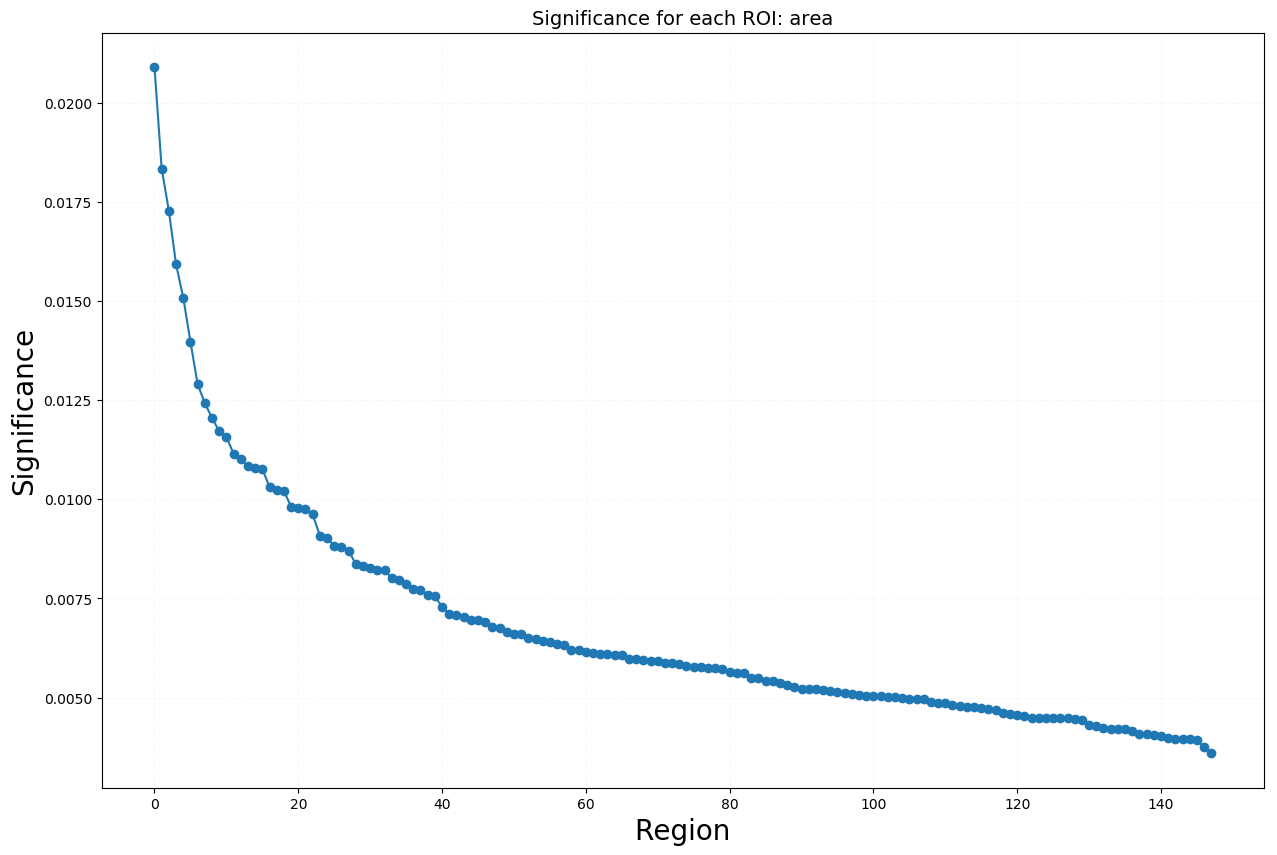

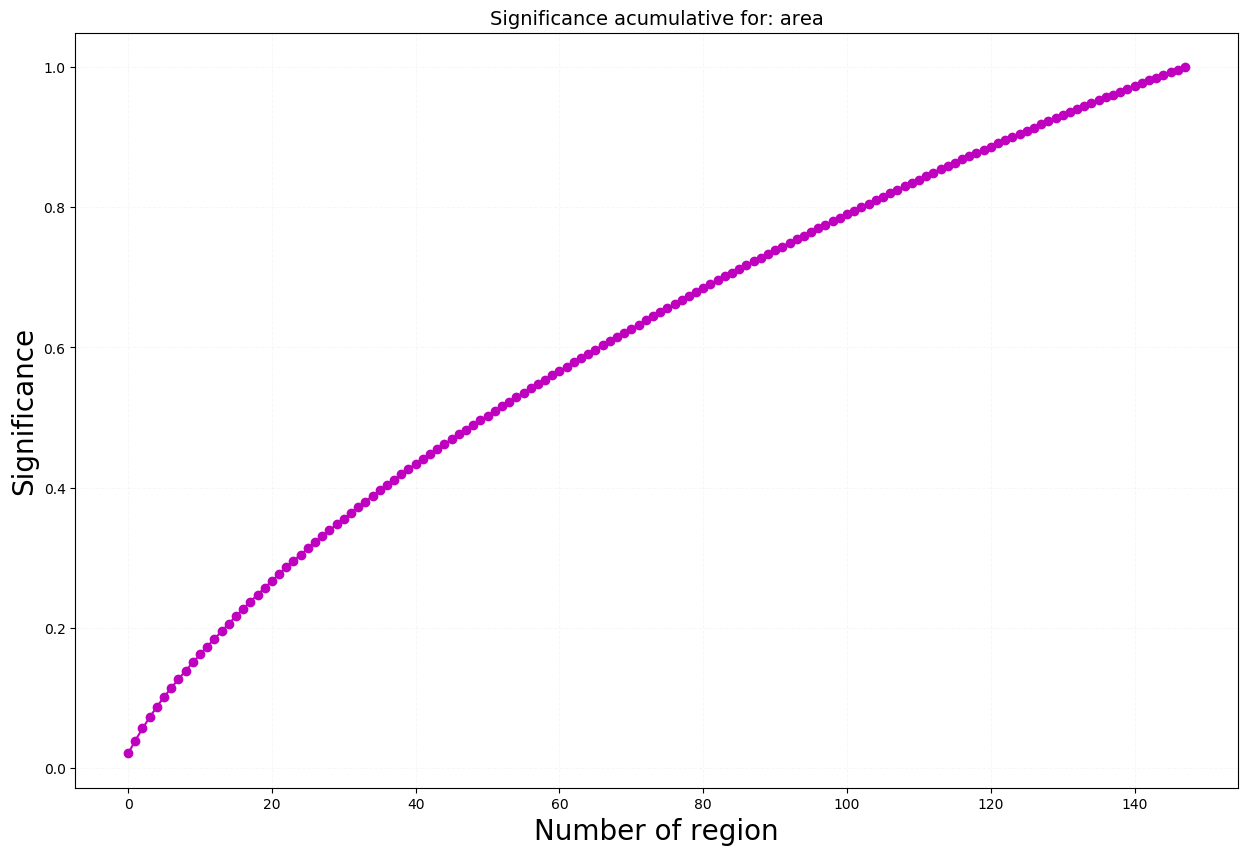

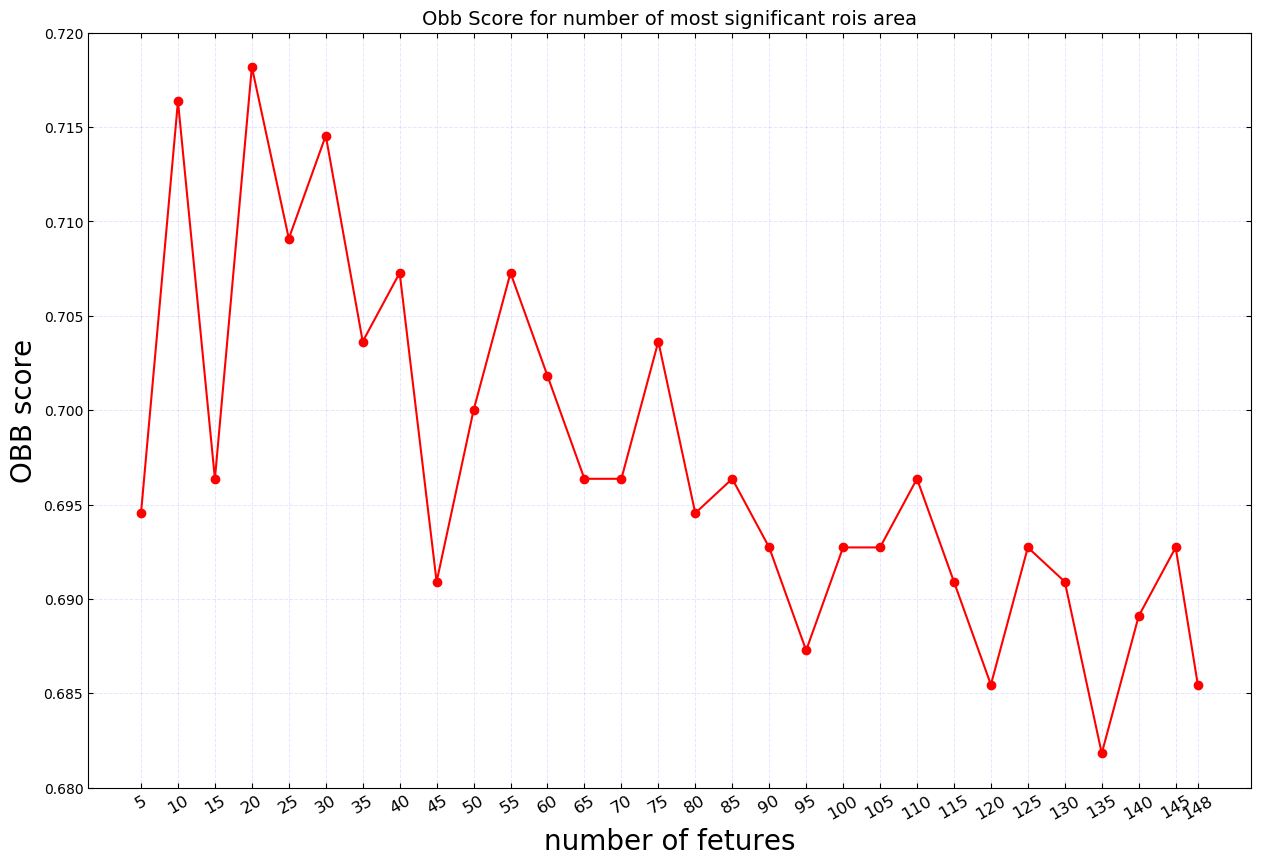

this is the best number for area: 20

number_of_Rois: 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.7s finished


number_of_Rois: 10



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.8s finished


number_of_Rois: 15



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.9s finished


number_of_Rois: 20



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.0s finished


number_of_Rois: 25



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.7s finished


number_of_Rois: 30



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.8s finished


number_of_Rois: 35



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.2s finished


number_of_Rois: 40



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.0s finished


number_of_Rois: 45



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.6s finished


number_of_Rois: 50



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 55



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.3s finished


number_of_Rois: 60



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.4s finished


number_of_Rois: 65



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.9s finished


number_of_Rois: 70



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 75



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.9s finished


number_of_Rois: 80



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 85



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


number_of_Rois: 90



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


number_of_Rois: 95



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.8s finished


number_of_Rois: 100



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.6s finished


number_of_Rois: 105



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.1s finished


number_of_Rois: 110



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.1s finished


number_of_Rois: 115



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.2s finished


number_of_Rois: 120



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 125



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.1s finished


number_of_Rois: 130



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.1s finished


number_of_Rois: 135



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.7s finished


number_of_Rois: 140



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.6s finished


number_of_Rois: 145



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   15.0s finished


number_of_Rois: 148



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


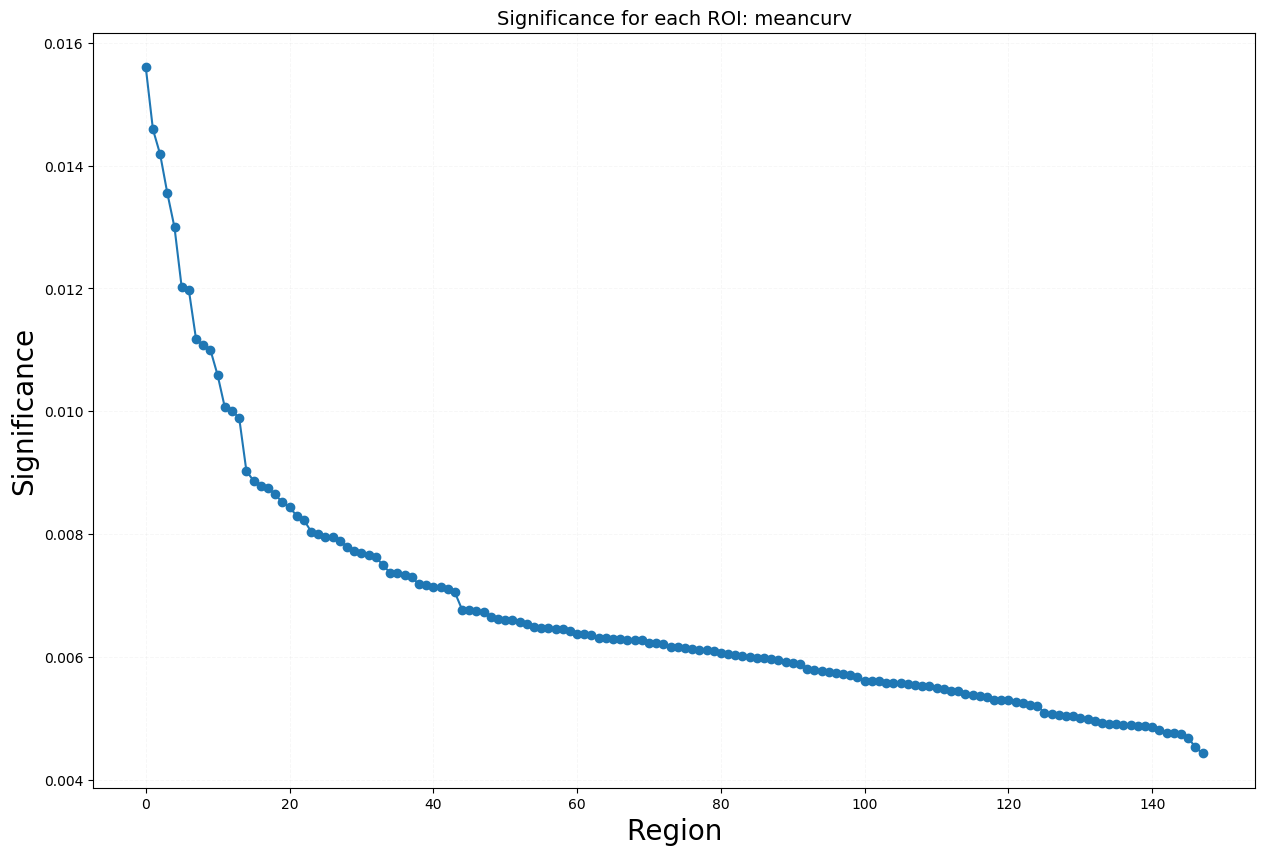

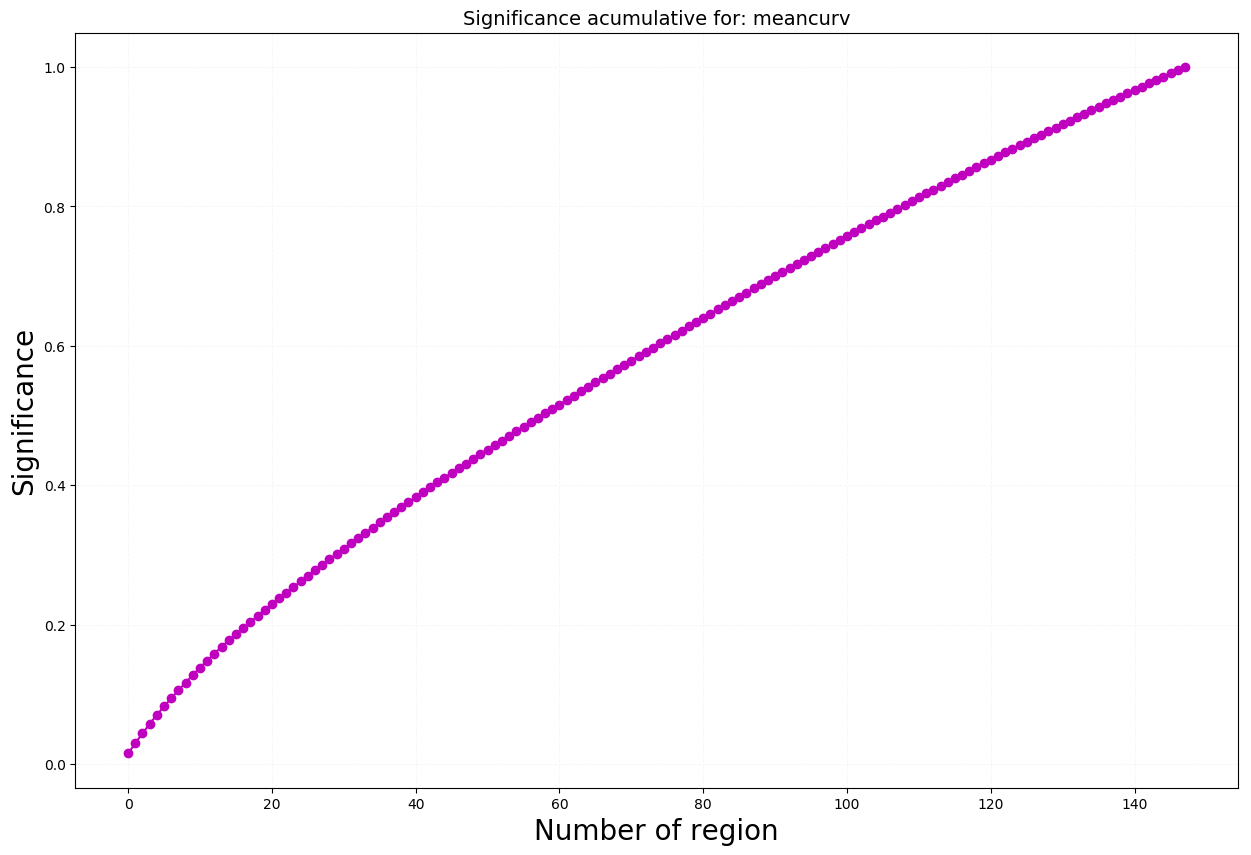

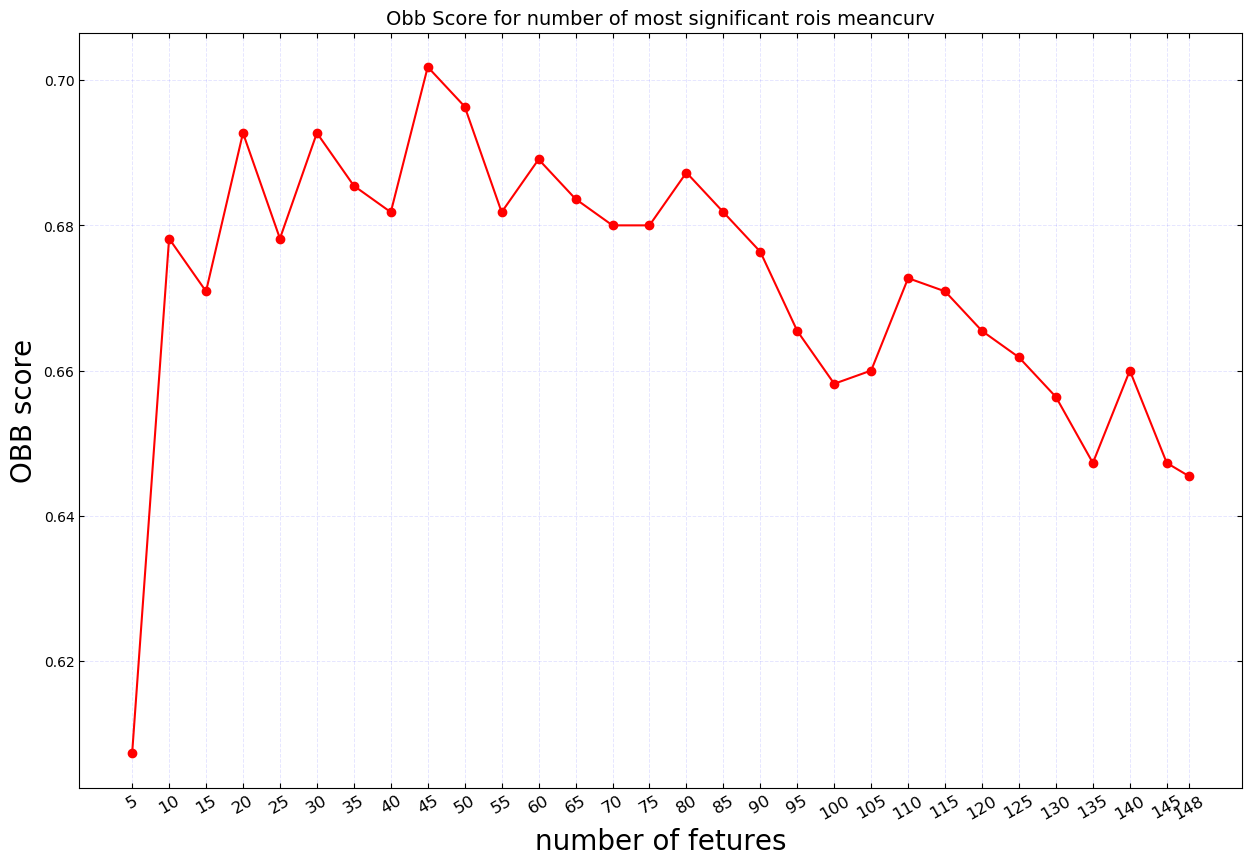

this is the best number for meancurv: 45

number_of_Rois: 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.4s finished


number_of_Rois: 10



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.8s finished


number_of_Rois: 15



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.7s finished


number_of_Rois: 20



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.2s finished


number_of_Rois: 25



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.6s finished


number_of_Rois: 30



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.3s finished


number_of_Rois: 35



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.5s finished


number_of_Rois: 40



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.1s finished


number_of_Rois: 45



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.1s finished


number_of_Rois: 50



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.6s finished


number_of_Rois: 55



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.9s finished


number_of_Rois: 60



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.7s finished


number_of_Rois: 65



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 70



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 75



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.5s finished


number_of_Rois: 80



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.8s finished


number_of_Rois: 85



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


number_of_Rois: 90



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 95



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 100



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   15.1s finished


number_of_Rois: 105



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   13.9s finished


number_of_Rois: 110



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.3s finished


number_of_Rois: 115



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.2s finished


number_of_Rois: 120



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.1s finished


number_of_Rois: 125



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.5s finished


number_of_Rois: 130



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.8s finished


number_of_Rois: 135



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.3s finished


number_of_Rois: 140



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.2s finished


number_of_Rois: 145



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.8s finished


number_of_Rois: 148



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.9s finished


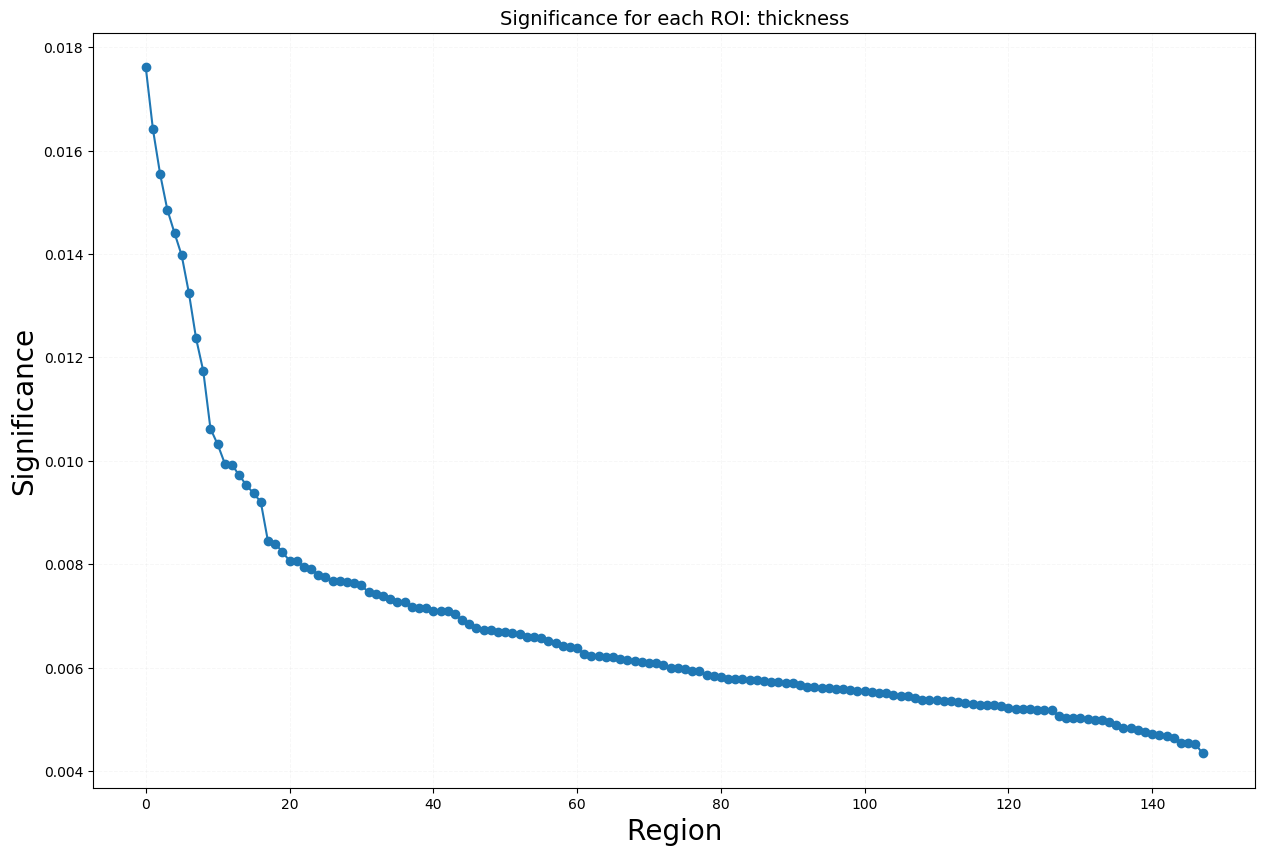

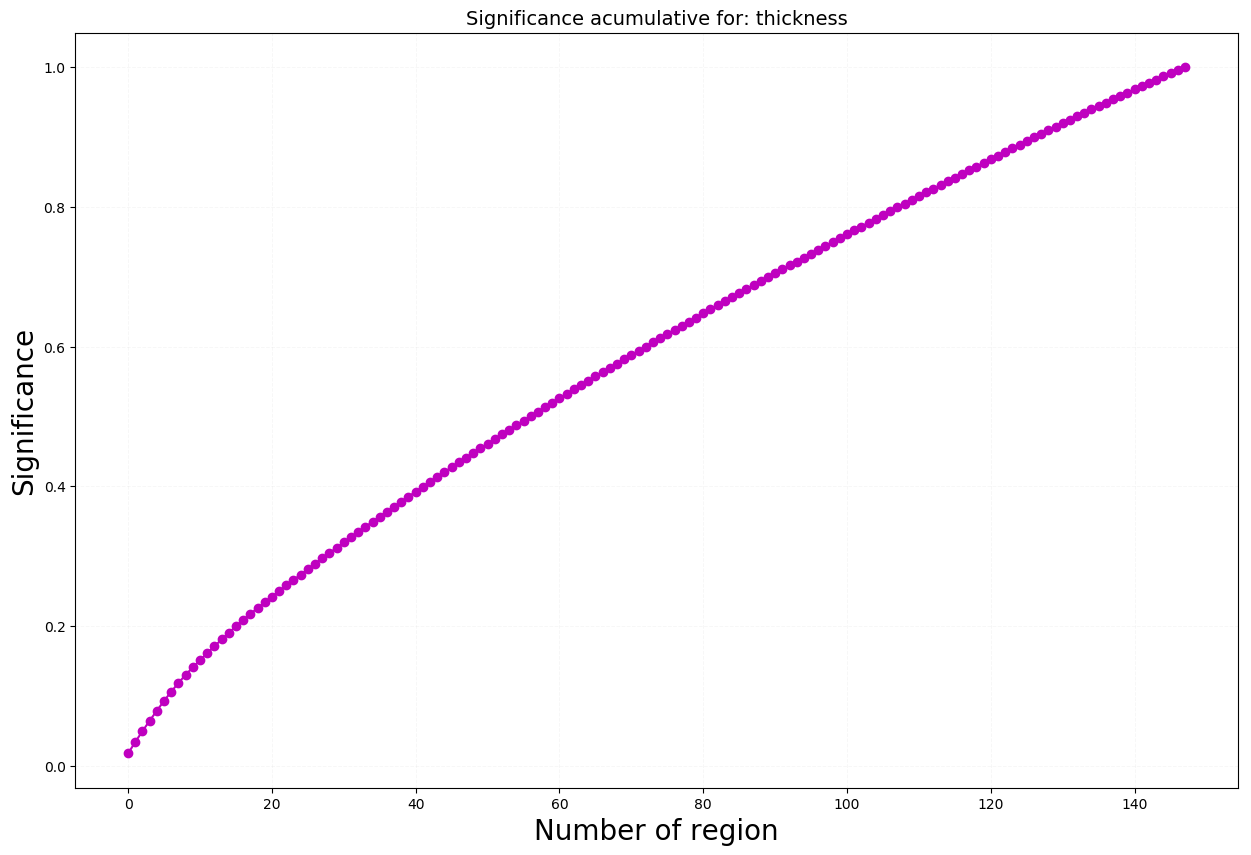

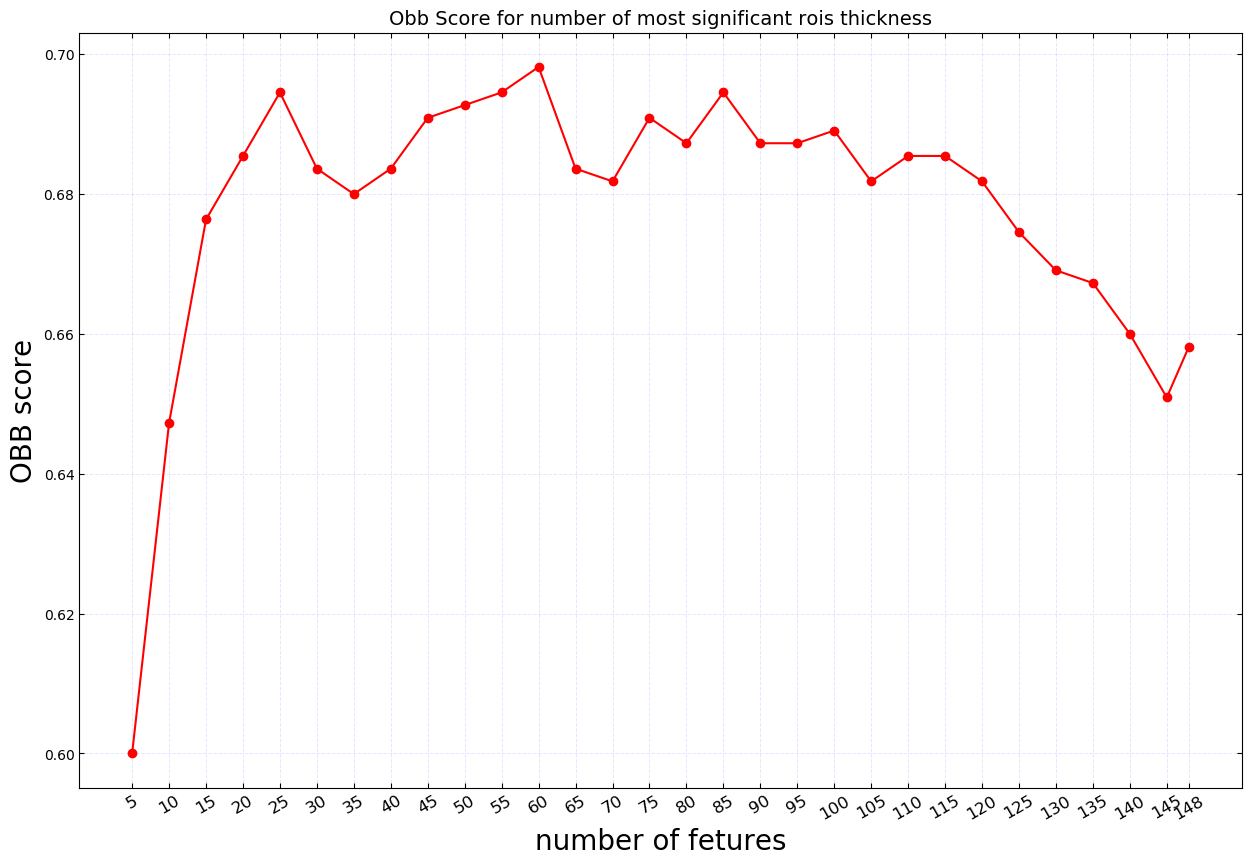

this is the best number for thickness: 60

number_of_Rois: 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.2s finished


number_of_Rois: 10



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.4s finished


number_of_Rois: 15



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.7s finished


number_of_Rois: 20



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.3s finished


number_of_Rois: 25



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    7.9s finished


number_of_Rois: 30



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 35



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.2s finished


number_of_Rois: 40



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.7s finished


number_of_Rois: 45



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.1s finished


number_of_Rois: 50



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.0s finished


number_of_Rois: 55



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.2s finished


number_of_Rois: 60



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.6s finished


number_of_Rois: 65



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.7s finished


number_of_Rois: 70



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    8.8s finished


number_of_Rois: 75



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.4s finished


number_of_Rois: 80



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


number_of_Rois: 85



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.4s finished


number_of_Rois: 90



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.2s finished


number_of_Rois: 95



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.5s finished


number_of_Rois: 100



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.7s finished


number_of_Rois: 105



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   10.7s finished


number_of_Rois: 110



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.4s finished


number_of_Rois: 115



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.3s finished


number_of_Rois: 120



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.4s finished


number_of_Rois: 125



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.4s finished


number_of_Rois: 130



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.2s finished


number_of_Rois: 135



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   12.5s finished


number_of_Rois: 140



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   11.4s finished


number_of_Rois: 145



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   16.0s finished


number_of_Rois: 148



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   14.3s finished


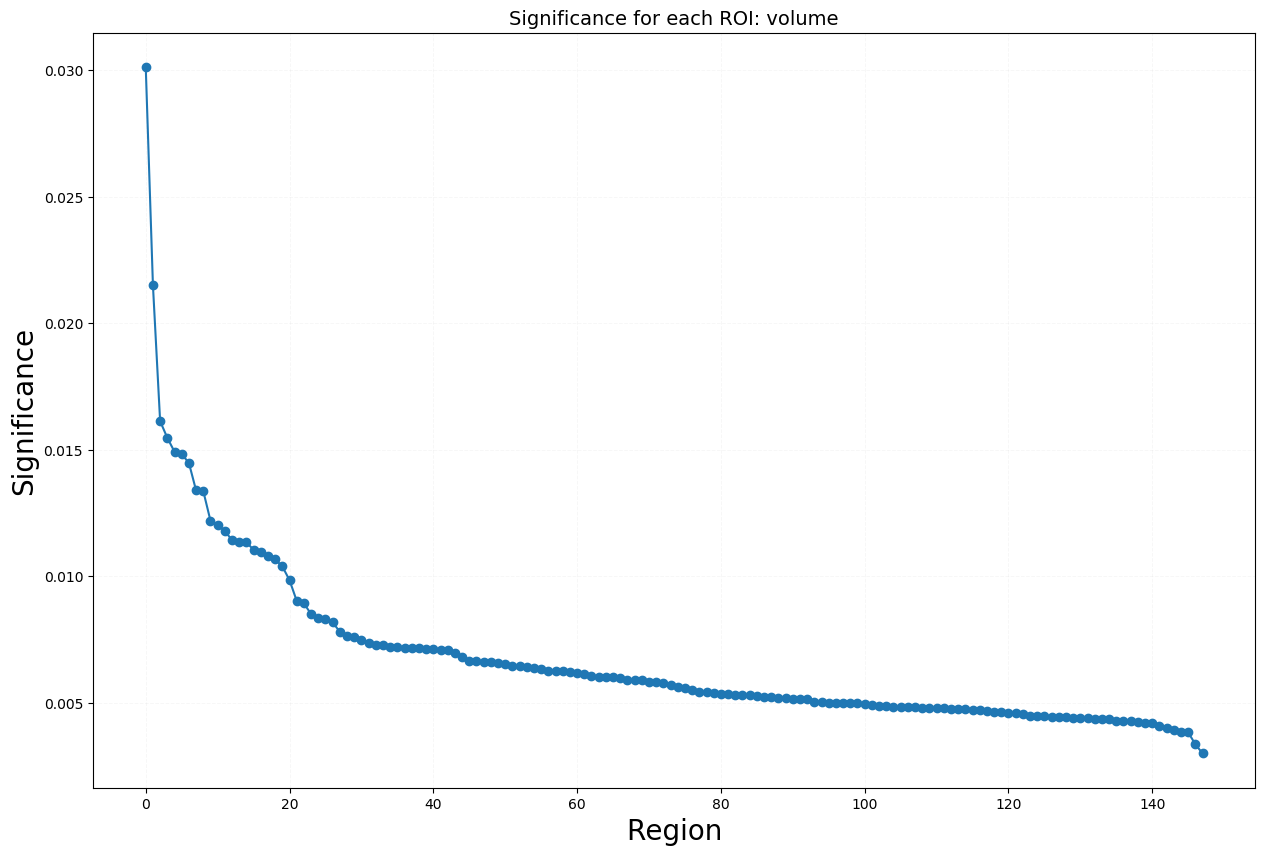

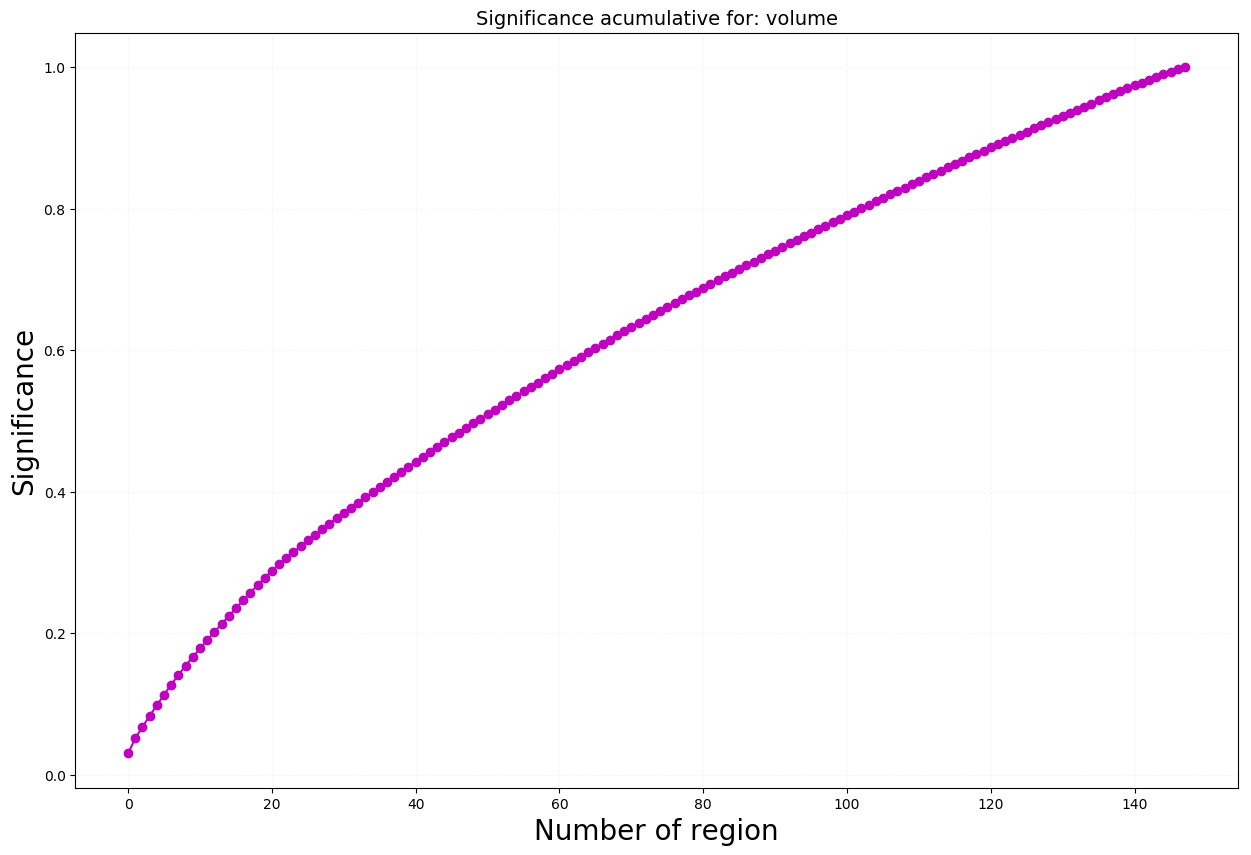

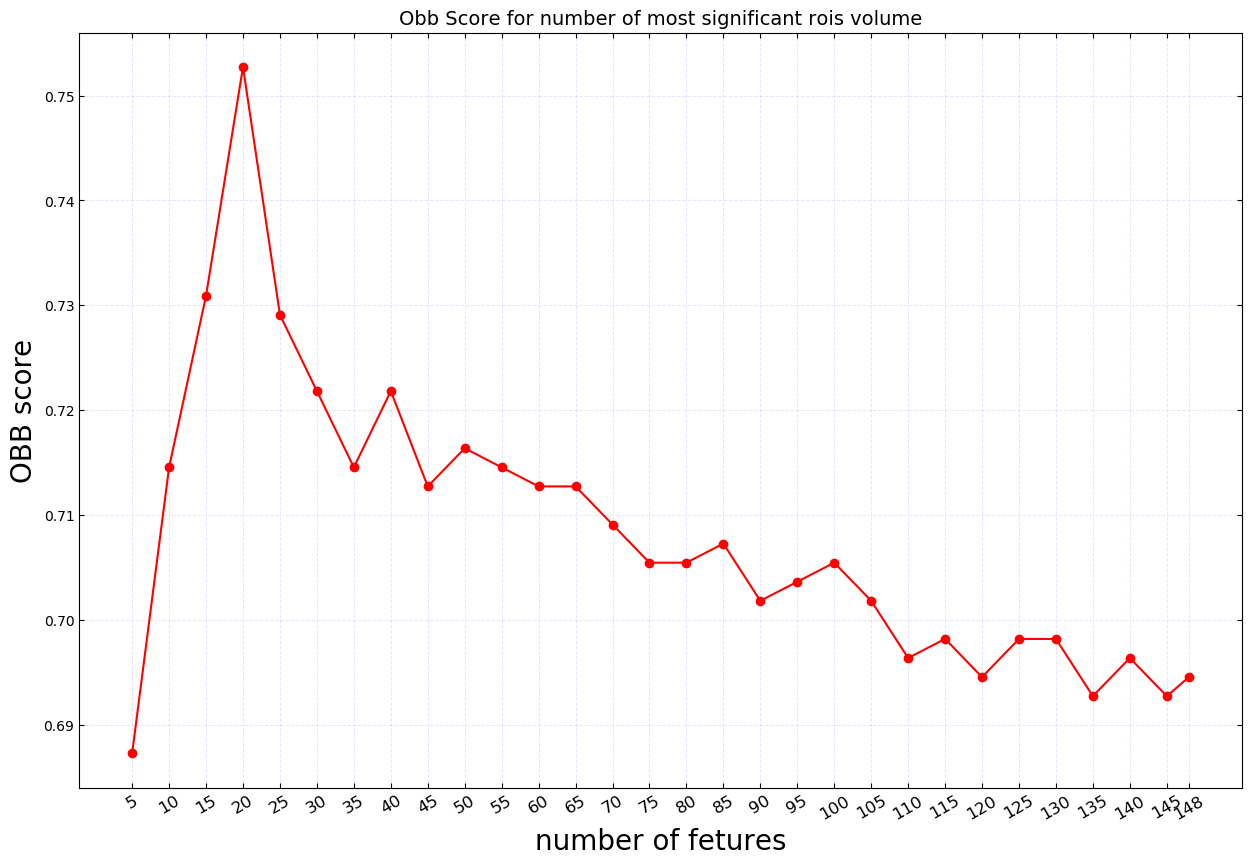

this is the best number for volume: 20



In [15]:
conter = 0
for feature, df_features in zip(df_X_tr, tables):
    
    data_feature = feature['data']
    data = df_features['data']
    name = df_features['name']
    
    data.sort_values("Significance", axis= 0, ascending = False, inplace = True)
    #print(data.head())
    
    vector = data['Significance'].values
    
    acumulative_significance = calc_acumulative_significance(vector)
    #print(acacumulative_significance)
    
    obb_scores = best_number_of_Rois(data, data_feature, df_y_tr)
    #print(obb_scores['obb_score'].values)
    
    plot_graf(data['Significance'].values,
              0,
              "-o", 
              'Significance for each ROI: '+ name, 
              "Region", 
              "Significance")
    
    plot_graf(acumulative_significance,
              0,
              "-mo", 
              'Significance acumulative for: '+ name, 
              "Number of region", 
              "Significance")
    
    plot_graf(obb_scores.index.values, 
              obb_scores['obb_score'].values, 
              "-ro", 
              'Obb Score for number of most significant rois ' + name, 
              "number of fetures", 
              "OBB score")
    
    data.to_csv("output/Random Forest (AllFeatures - Significance) "+ name +".csv")
    
    best_number_of_rois = max_result_obb_score(obb_scores)
    print("this is the best number for " + str(name) +": " + str(best_number_of_rois) + "\n")
    
    df_number_of_features.at[name] = best_number_of_rois
    
    # in this part we select the best number of rois for each model and we store it in a csv file 
    tables[conter]['data'][:int(best_number_of_rois)].to_csv("output/Random Forest (AllFeatures - Significance - "
                                                        + str(best_number_of_rois) + ")" 
                                                        + tables[conter]['name']+".csv")
    conter += 1
    
df_number_of_features.to_csv("output/Random Forest Best Number Of Features.csv")